In [1]:
import os
import argparse
import time
import datetime
from tqdm import tqdm

from munch import Munch
from torch.backends import cudnn
import torch
import numpy as np

from core.my_loader import get_train_loader, get_test_loader, InputFetcher
from core.my_solver import Solver
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader

from easydict import EasyDict as edict
from core.my_solver import compute_d_loss, compute_g_loss, moving_average, adv_loss, r1_reg, Sampler, LoaderSampler, tensor2img
from core.my_metrics import get_Z_pushed_loader_stats
from core.fid_score import calculate_frechet_distance

from IPython.display import clear_output
import matplotlib.pyplot as plt

def str2bool(v):
    return v.lower() in ('true')


def subdirs(dname):
    return [d for d in os.listdir(dname)
            if os.path.isdir(os.path.join(dname, d))]

args = edict({
    'img_size': 64,
    'num_domains': 2,
    'latent_dim': 16,
    'hidden_dim': 512,
    'style_dim': 64, 
    'lambda_reg': 1.0,
    'lambda_cyc': 1.0,
    'lambda_sty': 1.0,
    'lambda_ds': 1.0,
    'ds_iter': 100000,
    'w_hpf': -1.0,
    'randcrop_prob': 0.5,
    'total_iters': 100000,
    'resume_iter': 0,
    'batch_size': 16,
    'val_batch_size': 32,
    'lr': 1e-4,
    'f_lr': 1e-6,
    'beta1': 0.0,
    'beta2': 0.99,
    'weight_decay': 1e-4,
    'num_outs_per_domain': 10,
    'mode': 'train', 
    'num_workers': 4,
    'seed': 777,
    'train_img_dir': '/cache/selikhanovych/ot/data/celeba_train',
    'val_img_dir': '/cache/selikhanovych/ot/data/celeba_test',
    'sample_dir': 'expr/samples',
    'checkpoint_dir': '/cache/selikhanovych/ot/checkpoints/stargan-v2/celeba_male_celeba_female_64/checkpoints',
    'eval_dir': 'expr/eval',
    'result_dir': 'expr/results',
    'src_dir': 'assets/representative/celeba_hq/src',
    'ref_dir': 'assets/representative/celeba_hq/ref',
    'inp_dir': 'assets/representative/custom/female',
    'out_dir': 'assets/representative/celeba_hq/src/female',
    'wing_path': 'expr/checkpoints/wing.ckpt',
    'lm_path': 'expr/checkpoints/celeba_lm_mean.npz',
    'print_every': 10,
    'sample_every': 4000,
    'save_every': 4000,
    'eval_every': 4000,
    
    'target_dataset': 'celeba_female',
    'OUTPUT_PATH': '/cache/selikhanovych/ot/checkpoints/stargan-v2/celeba_male_celeba_female_64',
    'domains': {
        'source': 'male',
        'target': 'female',
    },
    'train_a': '/cache/selikhanovych/ot/data/celeba_train_male',
    'train_b': '/cache/selikhanovych/ot/data/celeba_train_female', 
    'test_a': '/cache/selikhanovych/ot/data/celeba_test_male',
    'test_b': '/cache/selikhanovych/ot/data/celeba_test_female',
    
    'n_epochs': 1
})


eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()

final_trg_index = -1
final_src_index = -1

for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            final_trg_index = trg_idx
            final_src_index = src_idx
            
print(final_trg_index, final_src_index)

0 0


In [2]:
domains

['female', 'male']

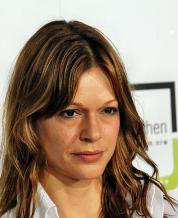

In [3]:
from PIL import Image
from glob import glob

path_to_image = "/cache/selikhanovych/ot/data/celeba_train/female"
images = glob(os.path.join(path_to_image, "*"))

Image.open(images[100])

In [4]:
cudnn.benchmark = True
torch.manual_seed(args.seed)

solver = Solver(args)

Number of parameters of generator: 32634883
Number of parameters of mapping_network: 2438272
Number of parameters of style_encoder: 20327808
Number of parameters of discriminator: 20263170
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...


In [5]:
assert len(subdirs(args.train_img_dir)) == args.num_domains
assert len(subdirs(args.val_img_dir)) == args.num_domains

In [6]:
loaders = Munch(src=get_train_loader(root=args.train_img_dir,
                                     which='source',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                ref=get_train_loader(root=args.train_img_dir,
                                     which='reference',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                val=get_test_loader(root=args.val_img_dir,
                                    img_size=args.img_size,
                                    batch_size=args.val_batch_size,
                                    shuffle=False,
                                    num_workers=args.num_workers))

Preparing DataLoader to fetch source images during the training phase...
Preparing DataLoader to fetch reference images during the training phase...
Preparing DataLoader for the generation phase...


Computing FID


  0%|          | 0/229 [00:00<?, ?it/s]

Calculating evaluation metrics...
Number of domains: 2
Compute FID for male2female
Preparing DataLoader for the generation phase...


100%|██████████| 229/229 [00:28<00:00,  7.91it/s]


FID = 12.687448780033975, best FID = 11.454134250321516, best iter = 52000
Plotting, iter = 60000
mode = train


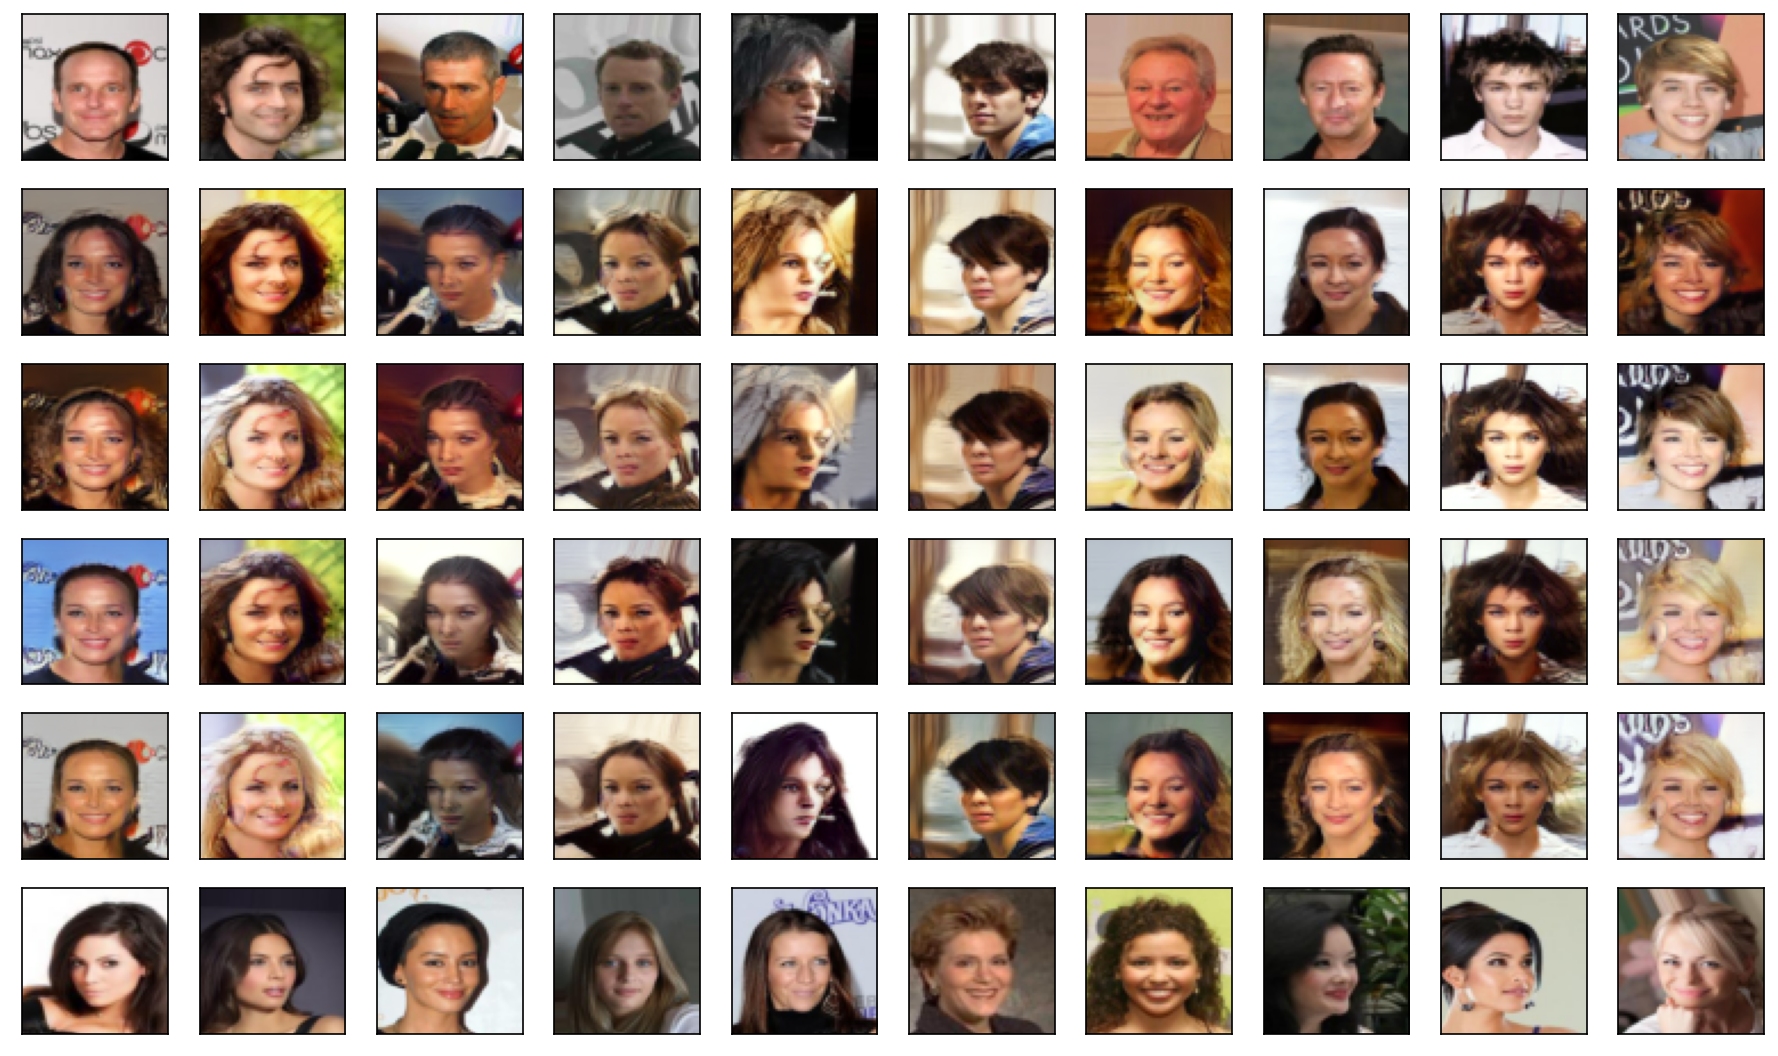

mode = test


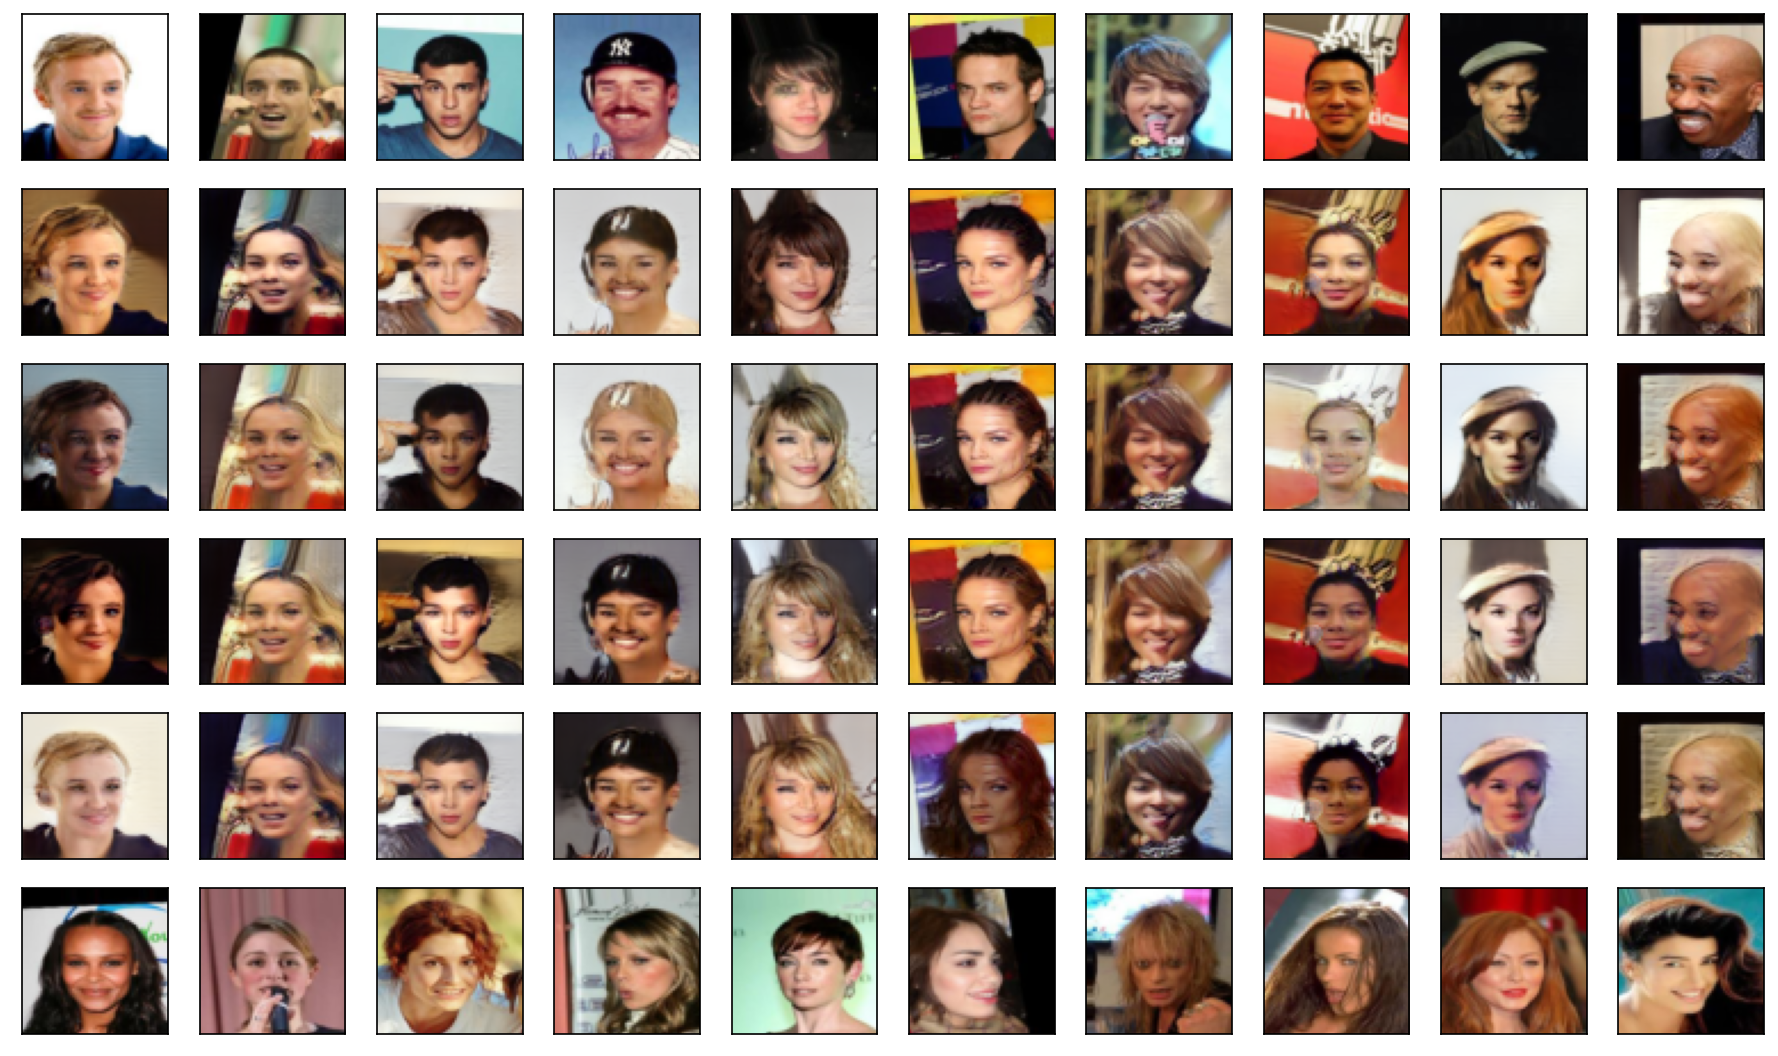

Elapsed time [17:36:34], Iteration [60011/100000], D/latent_real: [0.6528] D/latent_fake: [0.7521] D/latent_reg: [0.0221] D/ref_real: [0.5882] D/ref_fake: [0.6193] D/ref_reg: [0.0226] G/latent_adv: [0.8909] G/latent_sty: [0.1277] G/latent_ds: [0.4422] G/latent_cyc: [0.1691] G/ref_adv: [0.8547] G/ref_sty: [0.0897] G/ref_ds: [0.4387] G/ref_cyc: [0.1503] G/lambda_ds: [0.3999]
Elapsed time [17:36:44], Iteration [60021/100000], D/latent_real: [0.7637] D/latent_fake: [0.5983] D/latent_reg: [0.0249] D/ref_real: [0.5245] D/ref_fake: [0.6837] D/ref_reg: [0.0266] G/latent_adv: [1.0485] G/latent_sty: [0.1064] G/latent_ds: [0.4645] G/latent_cyc: [0.1595] G/ref_adv: [0.9409] G/ref_sty: [0.0838] G/ref_ds: [0.5199] G/ref_cyc: [0.1481] G/lambda_ds: [0.3998]
Elapsed time [17:36:54], Iteration [60031/100000], D/latent_real: [0.7058] D/latent_fake: [0.7397] D/latent_reg: [0.0249] D/ref_real: [0.5551] D/ref_fake: [0.6853] D/ref_reg: [0.0245] G/latent_adv: [0.8875] G/latent_sty: [0.1063] G/latent_ds: [0.53

Elapsed time [17:40:22], Iteration [60231/100000], D/latent_real: [0.8999] D/latent_fake: [0.6485] D/latent_reg: [0.0272] D/ref_real: [0.5086] D/ref_fake: [0.6908] D/ref_reg: [0.0206] G/latent_adv: [0.8657] G/latent_sty: [0.1030] G/latent_ds: [0.5440] G/latent_cyc: [0.1652] G/ref_adv: [0.8430] G/ref_sty: [0.1061] G/ref_ds: [0.5020] G/ref_cyc: [0.1639] G/lambda_ds: [0.3977]
Elapsed time [17:40:32], Iteration [60241/100000], D/latent_real: [0.7045] D/latent_fake: [0.6735] D/latent_reg: [0.0299] D/ref_real: [0.5924] D/ref_fake: [0.5935] D/ref_reg: [0.0290] G/latent_adv: [0.9787] G/latent_sty: [0.0978] G/latent_ds: [0.4456] G/latent_cyc: [0.1505] G/ref_adv: [0.8830] G/ref_sty: [0.1216] G/ref_ds: [0.4871] G/ref_cyc: [0.1356] G/lambda_ds: [0.3976]
Elapsed time [17:40:42], Iteration [60251/100000], D/latent_real: [0.6809] D/latent_fake: [0.6898] D/latent_reg: [0.0247] D/ref_real: [0.6001] D/ref_fake: [0.6163] D/ref_reg: [0.0257] G/latent_adv: [0.9412] G/latent_sty: [0.1034] G/latent_ds: [0.42

Elapsed time [17:44:11], Iteration [60451/100000], D/latent_real: [0.6377] D/latent_fake: [0.7669] D/latent_reg: [0.0231] D/ref_real: [0.6790] D/ref_fake: [0.4977] D/ref_reg: [0.0229] G/latent_adv: [0.8376] G/latent_sty: [0.1025] G/latent_ds: [0.4753] G/latent_cyc: [0.1520] G/ref_adv: [0.8568] G/ref_sty: [0.0870] G/ref_ds: [0.4889] G/ref_cyc: [0.1450] G/lambda_ds: [0.3955]
Elapsed time [17:44:22], Iteration [60461/100000], D/latent_real: [0.8704] D/latent_fake: [0.5813] D/latent_reg: [0.0262] D/ref_real: [0.4894] D/ref_fake: [0.8116] D/ref_reg: [0.0267] G/latent_adv: [1.0248] G/latent_sty: [0.1018] G/latent_ds: [0.4664] G/latent_cyc: [0.1377] G/ref_adv: [0.8918] G/ref_sty: [0.1061] G/ref_ds: [0.5568] G/ref_cyc: [0.1499] G/lambda_ds: [0.3954]
Elapsed time [17:44:32], Iteration [60471/100000], D/latent_real: [0.7520] D/latent_fake: [0.5543] D/latent_reg: [0.0289] D/ref_real: [0.4896] D/ref_fake: [0.7485] D/ref_reg: [0.0282] G/latent_adv: [1.0724] G/latent_sty: [0.1136] G/latent_ds: [0.50

Elapsed time [17:47:56], Iteration [60671/100000], D/latent_real: [0.8206] D/latent_fake: [0.5699] D/latent_reg: [0.0299] D/ref_real: [0.4532] D/ref_fake: [0.6598] D/ref_reg: [0.0301] G/latent_adv: [1.1141] G/latent_sty: [0.1023] G/latent_ds: [0.5195] G/latent_cyc: [0.1534] G/ref_adv: [1.0510] G/ref_sty: [0.1214] G/ref_ds: [0.4252] G/ref_cyc: [0.1504] G/lambda_ds: [0.3933]
Elapsed time [17:48:05], Iteration [60681/100000], D/latent_real: [0.7357] D/latent_fake: [0.5590] D/latent_reg: [0.0271] D/ref_real: [0.5082] D/ref_fake: [0.6078] D/ref_reg: [0.0281] G/latent_adv: [0.9924] G/latent_sty: [0.0956] G/latent_ds: [0.4598] G/latent_cyc: [0.1595] G/ref_adv: [0.9335] G/ref_sty: [0.1225] G/ref_ds: [0.5127] G/ref_cyc: [0.1567] G/lambda_ds: [0.3932]
Elapsed time [17:48:14], Iteration [60691/100000], D/latent_real: [0.6092] D/latent_fake: [0.8640] D/latent_reg: [0.0337] D/ref_real: [0.7787] D/ref_fake: [0.4755] D/ref_reg: [0.0285] G/latent_adv: [0.9309] G/latent_sty: [0.1038] G/latent_ds: [0.45

Elapsed time [17:51:46], Iteration [60891/100000], D/latent_real: [0.7588] D/latent_fake: [0.6259] D/latent_reg: [0.0297] D/ref_real: [0.4675] D/ref_fake: [0.6883] D/ref_reg: [0.0316] G/latent_adv: [1.3488] G/latent_sty: [0.1204] G/latent_ds: [0.4955] G/latent_cyc: [0.1618] G/ref_adv: [1.2141] G/ref_sty: [0.1156] G/ref_ds: [0.4446] G/ref_cyc: [0.1518] G/lambda_ds: [0.3911]
Elapsed time [17:51:57], Iteration [60901/100000], D/latent_real: [0.7419] D/latent_fake: [0.7269] D/latent_reg: [0.0303] D/ref_real: [0.6671] D/ref_fake: [0.5447] D/ref_reg: [0.0288] G/latent_adv: [1.0596] G/latent_sty: [0.0996] G/latent_ds: [0.3533] G/latent_cyc: [0.1523] G/ref_adv: [0.7873] G/ref_sty: [0.1612] G/ref_ds: [0.5360] G/ref_cyc: [0.1588] G/lambda_ds: [0.3910]
Elapsed time [17:52:08], Iteration [60911/100000], D/latent_real: [0.7931] D/latent_fake: [0.5856] D/latent_reg: [0.0264] D/ref_real: [0.5818] D/ref_fake: [0.6081] D/ref_reg: [0.0273] G/latent_adv: [0.9433] G/latent_sty: [0.0978] G/latent_ds: [0.43

Elapsed time [17:55:50], Iteration [61111/100000], D/latent_real: [0.6924] D/latent_fake: [0.7155] D/latent_reg: [0.0254] D/ref_real: [0.5428] D/ref_fake: [0.6893] D/ref_reg: [0.0217] G/latent_adv: [0.8722] G/latent_sty: [0.1002] G/latent_ds: [0.5093] G/latent_cyc: [0.1496] G/ref_adv: [0.8933] G/ref_sty: [0.1314] G/ref_ds: [0.4663] G/ref_cyc: [0.1480] G/lambda_ds: [0.3889]
Elapsed time [17:56:00], Iteration [61121/100000], D/latent_real: [0.8513] D/latent_fake: [0.5438] D/latent_reg: [0.0312] D/ref_real: [0.4652] D/ref_fake: [0.6734] D/ref_reg: [0.0293] G/latent_adv: [0.9837] G/latent_sty: [0.1057] G/latent_ds: [0.4076] G/latent_cyc: [0.1458] G/ref_adv: [0.9579] G/ref_sty: [0.1707] G/ref_ds: [0.4895] G/ref_cyc: [0.1331] G/lambda_ds: [0.3888]
Elapsed time [17:56:13], Iteration [61131/100000], D/latent_real: [0.8626] D/latent_fake: [0.5961] D/latent_reg: [0.0261] D/ref_real: [0.5145] D/ref_fake: [0.6620] D/ref_reg: [0.0237] G/latent_adv: [1.0342] G/latent_sty: [0.1145] G/latent_ds: [0.45

Elapsed time [17:59:41], Iteration [61331/100000], D/latent_real: [0.8055] D/latent_fake: [0.5241] D/latent_reg: [0.0321] D/ref_real: [0.4458] D/ref_fake: [0.7029] D/ref_reg: [0.0297] G/latent_adv: [1.2178] G/latent_sty: [0.1012] G/latent_ds: [0.3329] G/latent_cyc: [0.1588] G/ref_adv: [1.1117] G/ref_sty: [0.1987] G/ref_ds: [0.4616] G/ref_cyc: [0.1497] G/lambda_ds: [0.3867]
Elapsed time [17:59:52], Iteration [61341/100000], D/latent_real: [0.7639] D/latent_fake: [0.6637] D/latent_reg: [0.0292] D/ref_real: [0.5669] D/ref_fake: [0.5550] D/ref_reg: [0.0274] G/latent_adv: [0.9394] G/latent_sty: [0.1204] G/latent_ds: [0.4895] G/latent_cyc: [0.1683] G/ref_adv: [0.9051] G/ref_sty: [0.1995] G/ref_ds: [0.5371] G/ref_cyc: [0.1503] G/lambda_ds: [0.3866]
Elapsed time [18:00:02], Iteration [61351/100000], D/latent_real: [0.7271] D/latent_fake: [0.7122] D/latent_reg: [0.0303] D/ref_real: [0.6530] D/ref_fake: [0.5669] D/ref_reg: [0.0285] G/latent_adv: [0.9603] G/latent_sty: [0.1064] G/latent_ds: [0.34

Elapsed time [18:03:29], Iteration [61551/100000], D/latent_real: [0.7329] D/latent_fake: [0.6932] D/latent_reg: [0.0326] D/ref_real: [0.6024] D/ref_fake: [0.6077] D/ref_reg: [0.0323] G/latent_adv: [0.9011] G/latent_sty: [0.1043] G/latent_ds: [0.4155] G/latent_cyc: [0.1458] G/ref_adv: [0.8452] G/ref_sty: [0.1823] G/ref_ds: [0.5782] G/ref_cyc: [0.1436] G/lambda_ds: [0.3845]
Elapsed time [18:03:39], Iteration [61561/100000], D/latent_real: [0.7386] D/latent_fake: [0.6502] D/latent_reg: [0.0282] D/ref_real: [0.6342] D/ref_fake: [0.5841] D/ref_reg: [0.0290] G/latent_adv: [0.8932] G/latent_sty: [0.1044] G/latent_ds: [0.5221] G/latent_cyc: [0.1695] G/ref_adv: [0.8415] G/ref_sty: [0.1972] G/ref_ds: [0.4863] G/ref_cyc: [0.1610] G/lambda_ds: [0.3844]
Elapsed time [18:03:50], Iteration [61571/100000], D/latent_real: [0.7519] D/latent_fake: [0.6028] D/latent_reg: [0.0338] D/ref_real: [0.5486] D/ref_fake: [0.5967] D/ref_reg: [0.0348] G/latent_adv: [0.9048] G/latent_sty: [0.1039] G/latent_ds: [0.44

In [ ]:
device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

print('Start training...')
start_time = time.time()
for i in range(args.resume_iter, args.total_iters):
    # fetch images and labels
    inputs = next(fetcher)
    x_real, y_org = inputs.x_src, inputs.y_src
    x_ref, x_ref2, y_trg = inputs.x_ref, inputs.x_ref2, inputs.y_ref
    z_trg, z_trg2 = inputs.z_trg, inputs.z_trg2

    masks = nets.fan.get_heatmap(x_real) if args.w_hpf > 0 else None

    # train the discriminator
    d_loss, d_losses_latent = compute_d_loss(
        nets, args, x_real, y_org, y_trg, z_trg=z_trg, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    d_loss, d_losses_ref = compute_d_loss(
        nets, args, x_real, y_org, y_trg, x_ref=x_ref, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    # train the generator
    g_loss, g_losses_latent = compute_g_loss(
        nets, args, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2], masks=masks)
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()
    optims.mapping_network.step()
    optims.style_encoder.step()

    g_loss, g_losses_ref = compute_g_loss(
        nets, args, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2], masks=masks)
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()

    # compute moving average of network parameters
    moving_average(nets.generator, nets_ema.generator, beta=0.999)
    moving_average(nets.mapping_network, nets_ema.mapping_network, beta=0.999)
    moving_average(nets.style_encoder, nets_ema.style_encoder, beta=0.999)

    # decay weight for diversity sensitive loss
    if args.lambda_ds > 0:
        args.lambda_ds -= (initial_lambda_ds / args.ds_iter)

    # print out log info
    if i % args.print_every == 0:
        elapsed = time.time() - start_time
        elapsed = str(datetime.timedelta(seconds=elapsed))[:-7]
        log = "Elapsed time [%s], Iteration [%i/%i], " % (elapsed, i+1, args.total_iters)
        all_losses = dict()
        for loss, prefix in zip([d_losses_latent, d_losses_ref, g_losses_latent, g_losses_ref],
                                ['D/latent_', 'D/ref_', 'G/latent_', 'G/ref_']):
            for key, value in loss.items():
                all_losses[prefix + key] = value
        all_losses['G/lambda_ds'] = args.lambda_ds
        log += ' '.join(['%s: [%.4f]' % (key, value) for key, value in all_losses.items()])
        print(log)

    # save model checkpoints
    if i % args.save_every == 0:
        solver._save_checkpoint(step=i+1)

    # compute FID and LPIPS if necessary
    if i % args.eval_every == 0:
        clear_output(wait=True)
        print('Computing FID')
        nets_ema.mapping_network.eval()
        nets_ema.generator.eval()
        mu, sigma = get_Z_pushed_loader_stats(nets_ema, args.domains, args, device,
                                              batch_size=37, n_epochs=args.n_epochs)
        fid = calculate_frechet_distance(solver.mu_data, solver.sigma_data, mu, sigma)
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")
        solver.writer.add_scalar('test fid',
                               fid,
                               i + 1)
        del mu, sigma
        if fid < solver.BEST_FID:
            solver.BEST_FID = fid
            solver.best_iter = i

        num_examples = 4
        Y_fakes = []
        Y_test_fakes = []

        for v in range(num_examples):
            N = solver.X_fixed.size(0)
            x_src = solver.X_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()
            
            fake_Y_numpy = tensor2img(x_fake)
            Y_fakes.append(fake_Y_numpy)
            
            N = solver.X_test_fixed.size(0)
            x_src = solver.X_test_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()

            fake_Y_test_numpy = tensor2img(x_fake)
            Y_test_fakes.append(fake_Y_test_numpy)

        real_X_numpy = tensor2img(solver.X_fixed)
        real_X_test_numpy = tensor2img(solver.X_test_fixed)
        real_Y_numpy = tensor2img(solver.Y_fixed)
        real_Y_test_numpy = tensor2img(solver.Y_test_fixed)

        X_tensors = [real_X_numpy, real_X_test_numpy]
        Y_tensors = [real_Y_numpy, real_Y_test_numpy]

        Y_fakes_tensors = [Y_fakes, Y_test_fakes]

        modes = ["train", "test"]

        print(f"Plotting, iter = {i}")

        for t in range(2):
            print(f"mode = {modes[t]}")
            fig, axes = plt.subplots(6, 10, figsize=(15, 9), dpi=150)
            X_tensor = X_tensors[t]
            Y_tensor = Y_tensors[t]
            Y_fake_tensor = Y_fakes_tensors[t]

            for j in range(10):
                axes[0][j].imshow(X_tensor[j])
                axes[0][j].get_xaxis().set_visible(False)
                axes[0][j].get_yaxis().set_visible(False)

            for j in range(10):
                axes[5][j].imshow(Y_tensor[j])
                axes[5][j].get_xaxis().set_visible(False)
                axes[5][j].get_yaxis().set_visible(False)

            for i in range(4):
                for j in range(10):
                    cur_img = Y_fake_tensor[i][j]

                    axes[i + 1][j].imshow(cur_img)
                    axes[i + 1][j].get_xaxis().set_visible(False)
                    axes[i + 1][j].get_yaxis().set_visible(False)

            plt.show(fig)
            solver.writer.add_figure(f'Step {i + 1}, {modes[t]}',
                                     fig,
                                     global_step=i + 1)
            plt.close(fig)
            
        nets_ema.mapping_network.train()
        nets_ema.generator.train()